# Evaluation Function

In [2]:
import json
import numpy as np
from PIL import Image
import os

def load_json(path):
    with open(path, "r") as file:
        data = json.load(file)
    return data

def bb_intersection_over_union(box1, box2):
    # determine the (x, y)-coordinates of the intersection rectangle
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate the (x, y)-coordinates of the intersection rectangle
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1+w1, x2+w2)
    yi2 = min(y1+h1, y2+h2)

    # Compute the area of intersection rectangle
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Compute the intersection over union by taking the intersection area
    # and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = inter_area / float(box1_area + box2_area - inter_area)

    # return the intersection over union value
    return iou

def calculate_iou_list(ground_truth, predictions):
    results = []
    for gt in ground_truth:
        iou_values = [bb_intersection_over_union(gt, pred) for pred in predictions]
        results.append(iou_values)
    return results



base_path = "/forest_3d_app/yolov5/trims_dataset/test/"
ground_truths_path = base_path +  "_annotations.coco.json"
truths = load_json(ground_truths_path)


images, annotations = truths["images"], truths["annotations"]

bb_intersection_over_union([187, 305, 165, 171], [187, 305, 165, 171])
    

1.0241767702130713

In [2]:
annotations

[{'area': 3577,
  'bbox': [260, 81, 98, 36.5],
  'category_id': 1,
  'id': 0,
  'image_id': 0,
  'iscrowd': 0,
  'segmentation': []},
 {'area': 7504,
  'bbox': [242, 111, 112, 67],
  'category_id': 1,
  'id': 1,
  'image_id': 0,
  'iscrowd': 0,
  'segmentation': []},
 {'area': 13255,
  'bbox': [222, 184, 120.5, 110],
  'category_id': 1,
  'id': 2,
  'image_id': 0,
  'iscrowd': 0,
  'segmentation': []},
 {'area': 6742.25,
  'bbox': [253, 297, 90.5, 74.5],
  'category_id': 1,
  'id': 3,
  'image_id': 0,
  'iscrowd': 0,
  'segmentation': []},
 {'area': 6359.25,
  'bbox': [242, 370, 91.5, 69.5],
  'category_id': 1,
  'id': 4,
  'image_id': 0,
  'iscrowd': 0,
  'segmentation': []},
 {'area': 8952.75,
  'bbox': [237, 452, 103.5, 86.5],
  'category_id': 1,
  'id': 5,
  'image_id': 0,
  'iscrowd': 0,
  'segmentation': []},
 {'area': 8341.5,
  'bbox': [244, 539, 100.5, 83],
  'category_id': 1,
  'id': 6,
  'image_id': 0,
  'iscrowd': 0,
  'segmentation': []},
 {'area': 11904,
  'bbox': [443, 78

# Yolo V3

In [5]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

def load_yolo_model(weights, config, classes):
    net = cv2.dnn.readNet(weights, config)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    class_names = [line.strip() for line in open(classes)]

    return net, output_layers, class_names

def predict_image(image_path, net, output_layers, class_names):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), swapRB=False, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence >= 0.50:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
                
                
                
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                
                boxes.append([x, y, x + w, y + h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    

    for i in boxes:
        
            
        box = i
        x1, y1, x2, y2 = box
        color = (0, 255, 0)
        cv2.rectangle(img, (x1, y1), (x2 , y2 ), color, 2)
        cv2.putText(img, "", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    plt.title("Yolo Prediction")
    plt.imshow(img)
    plt.show()
    return boxes


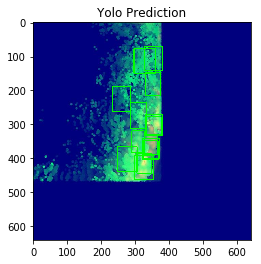

In [6]:
weights = "/forest_3d_app/3d_forest/forest_3d_app/models/models/detection/hvp/yolov3.weights"
config = "/forest_3d_app/3d_forest/forest_3d_app/models/models/detection/hvp/yolov3.cfg"
classes = "/forest_3d_app/3d_forest/forest_3d_app/models/models/detection/hvp/obj.names"
image_path = "/forest_3d_app/yolov5/trims_dataset/test/160_2-170_2_slam_slice_no_15_jpeg.rf.22e75754361c4b834a74ec5febe1f3c9.jpg"
annotation_path = "/forest_3d_app/yolov5/trims_dataset/test/"
net, output_layers, class_names = load_yolo_model(weights, config, classes)
prediction = predict_image(image_path, net, output_layers, class_names)


# Draw Ground Truths

In [15]:

def plot_bbox(image_path, bbox):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in bbox:
        color = (0, 255, 0)
        x1, y1, x2,y2 = box
        cv2.rectangle(img, (x1, y1), (x2 , y2 ), color, 2)
    plt.title("Ground Truth")
    plt.imshow(img)
    plt.show()



# Yolo3 Evaluation

prediction


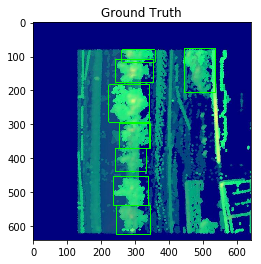

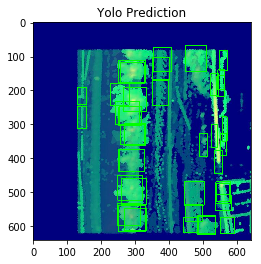

IOU per Image  0.12510292845915663
prediction


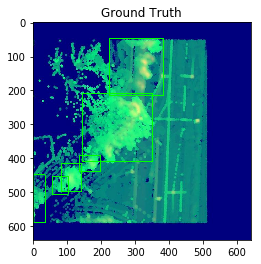

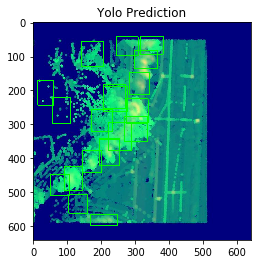

IOU per Image  0.11064102173170894
prediction


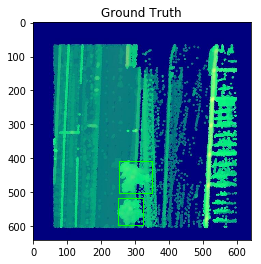

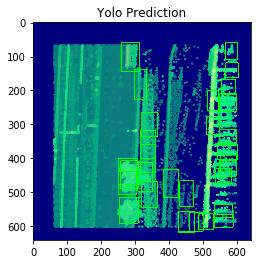

IOU per Image  0.2029064527017596
prediction


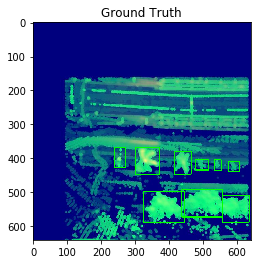

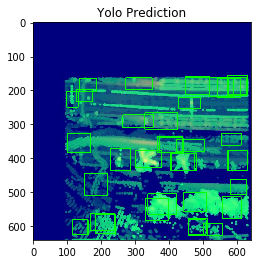

IOU per Image  0.18040393078075873
prediction


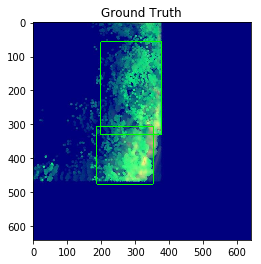

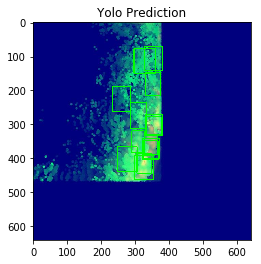

IOU per Image  0.22527570423559254


In [10]:

for image in images:
    # Getting file path
    image_path = base_path + image["file_name"]
    
    # Getting ground truth
    ground_truth_bbox = []
    for annotation in annotations:
        if image['id'] == annotation['image_id']:
            box = [int(i) for i in annotation["bbox"]]
            box = [box[0], box[1], box[0] + box[2], box[1]+box[3]] 
            ground_truth_bbox.append(box)
    
    # Plot ground_truth
    print("prediction")
    plot_bbox(image_path, ground_truth_bbox)
    # Getting prediction
    prediction = predict_image(image_path, net, output_layers, class_names)
    iou = calculate_iou_list(ground_truth_bbox, prediction)
    average_iou = np.mean(np.concatenate(iou))
    print("IOU per Image ", average_iou)
    #

# Yolo 5

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-28 Python-3.9.16 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3070, 7979MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


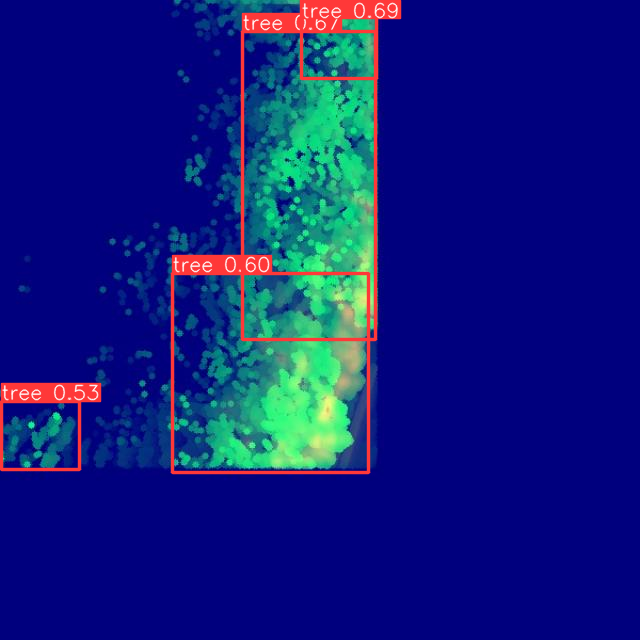

In [20]:
import torch
from PIL import Image

def prediction_function(model, image_path):
    # Load model
    
    
    # Load weights
#     model.load_state_dict(torch.load(weights))
    
    # Load image
    img = Image.open(image_path)

    # Get predictions
    results = model(img)

    # Show results
    results.show()

    return results
weights = "/forest_3d_app/yolov5/runs/train/exp7/weights/best.pt"
source = "/forest_3d_app/yolov5/trims_dataset/test/160_2-170_2_slam_slice_no_15_jpeg.rf.22e75754361c4b834a74ec5febe1f3c9.jpg"
model = torch.hub.load('ultralytics/yolov5', 'custom', weights)
results = prediction_function(model, source)
# Usage:
# preds = prediction_function('path_to_weights/best.pt', 'path_to_image.jpg')
# print(preds)

In [23]:
list_bbox = [list(i) for i in np.asarray(results.pandas().xyxy[0][["xmin", "ymin", "xmax","ymax"]].values)]
prediction = convert_float_to_int(list_bbox)

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 640x640 4 trees
Speed: 2.8ms pre-process, 5.4ms inference, 1.6ms NMS per image at shape (1, 3, 640, 640)

In [31]:
list(results.pandas().xyxy[0].confidence.values)

[0.6948353052139282,
 0.6706444621086121,
 0.6026719808578491,
 0.5252061486244202]

In [13]:
def convert_float_to_int(float_list):
    int_list = [[int(float_val) for float_val in sublist] for sublist in float_list]
    return int_list

list_bbox = [list(i) for i in np.asarray(results.pandas().xyxy[0][["xmin", "ymin", "xmax","ymax"]].values)]
convert_float_to_int(list_bbox)


[[301, 0, 376, 78],
 [242, 31, 375, 339],
 [172, 273, 368, 472],
 [1, 401, 79, 469]]

# Yolo 5 Evaluation

prediction


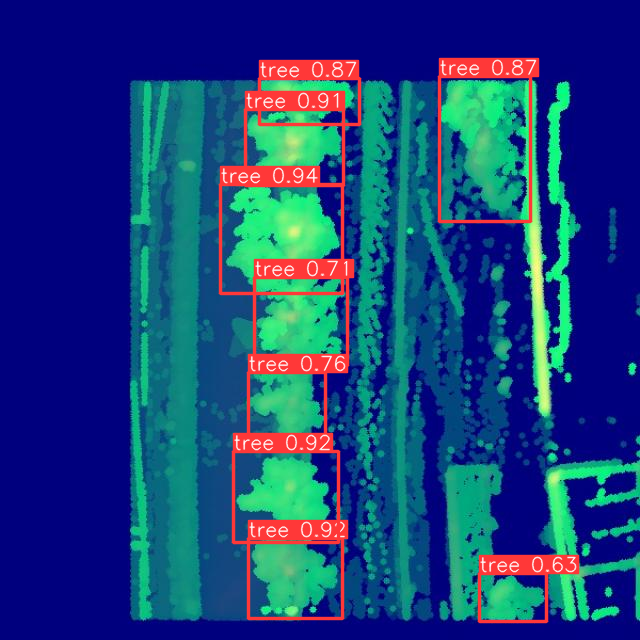

IOU per Image  0.2237392155818027
prediction


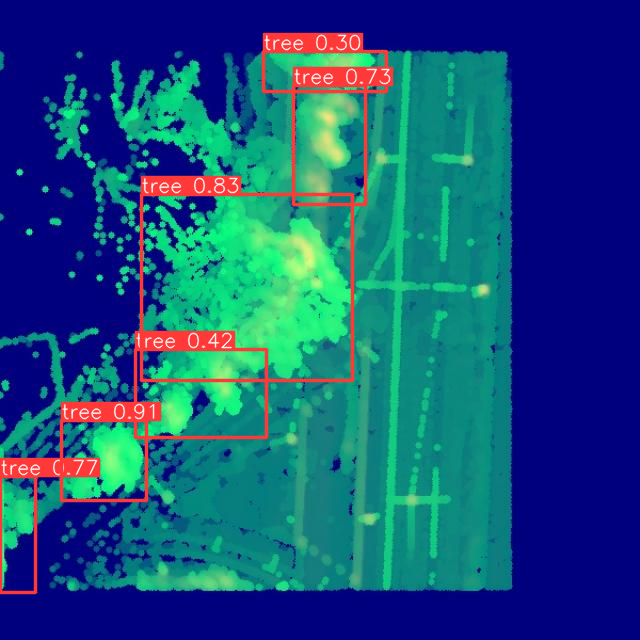

IOU per Image  0.16867831291049754
prediction


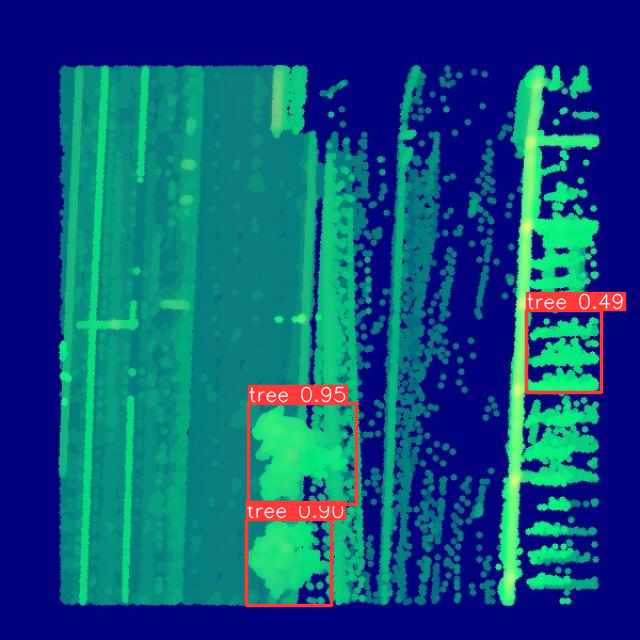

IOU per Image  0.5090189395957644
prediction


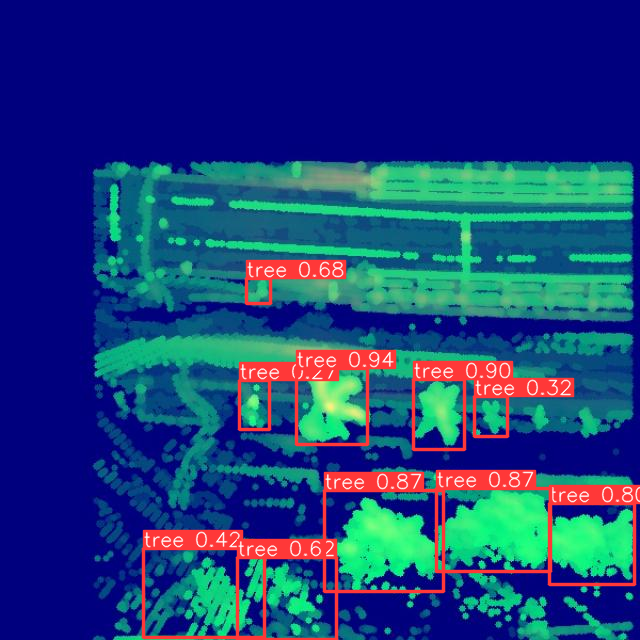

IOU per Image  0.2885179447845436
prediction


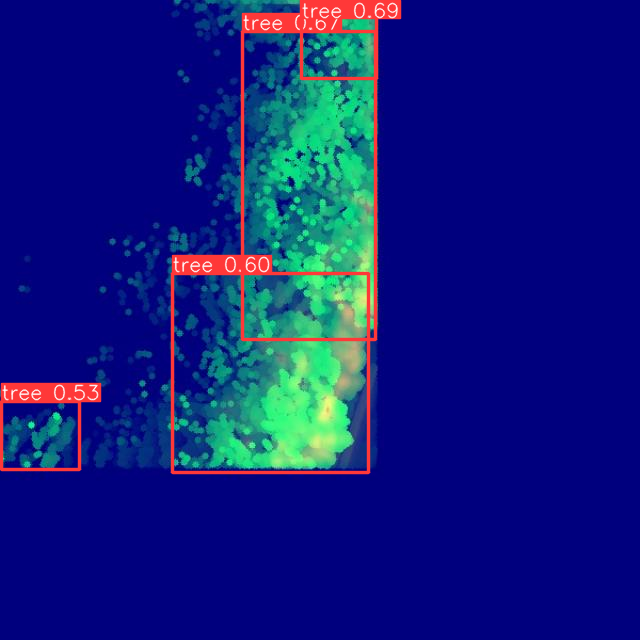

IOU per Image  0.22748040886865045


In [22]:
import cv2
import matplotlib.pyplot as plt
for image in images:
    # Getting file path
    image_path = base_path + image["file_name"]
    
    # Getting ground truth
    ground_truth_bbox = []
    for annotation in annotations:
        if image['id'] == annotation['image_id']:
            box = [int(i) for i in annotation["bbox"]]
            box = [box[0], box[1], box[0] + box[2], box[1]+box[3]] 
            ground_truth_bbox.append(box)
    
    # Plot ground_truth
    print("prediction")
    plot_bbox(image_path, ground_truth_bbox)
    # Getting prediction
    results = prediction_function(model, image_path)
    list_bbox = [list(i) for i in np.asarray(results.pandas().xyxy[0][["xmin", "ymin", "xmax","ymax"]].values)]
    prediction = convert_float_to_int(list_bbox)
    
    # Calculating IOU
    iou = calculate_iou_list(ground_truth_bbox, prediction)
    average_iou = np.mean(np.concatenate(iou))
    print("IOU per Image ", average_iou)
    #